# Staff Impact Model Comparison

Compare different regression models for predicting staff impact on morale and satisfaction.

**Models tested:**
- Ridge Regression (L2 regularization)
- Lasso Regression (L1 regularization, feature selection)
- ElasticNet (L1 + L2 regularization)
- Random Forest Regressor
- XGBoost (gradient boosting)
- LightGBM (fast gradient boosting)

**Features:**
- Staff presence (binary)
- Staff interaction terms (all pairs)
- Event dummies (equipment_failure, staff_training, etc.)
- Log-transformed target variants

**Data cleaning:**
- Filter anomaly weeks (no staff assigned: weeks 3,6,9,12,15,18,21,24,27,30,33,36,39,42,45,48,51)

**Evaluation metrics:**
- R² Score (variance explained)
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Cross-validation: LOO for linear models, 10-fold for tree models

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Anomaly weeks (no staff assigned)
ANOMALY_WEEKS = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]

In [36]:
# Load data
services_df = pd.read_csv('./data/services_weekly.csv')
staff_schedule_df = pd.read_csv('./data/staff_schedule.csv')

print(f"Services data: {services_df.shape}")
print(f"Staff schedule data: {staff_schedule_df.shape}")
print(f"\nDepartments: {services_df['service'].unique()}")
print(f"Roles: {staff_schedule_df['role'].unique()}")

Services data: (208, 11)
Staff schedule data: (6552, 6)

Departments: ['emergency' 'surgery' 'general_medicine' 'ICU']
Roles: ['doctor' 'nurse' 'nursing_assistant']


In [37]:
def prepare_data_for_department(services_df, staff_schedule_df, department, week_range=(1, 52), 
                                    include_interactions=False, log_transform=False):
    """
    Prepare feature matrix and target vectors for a specific department.
    
    Features:
    - Staff presence (binary)
    - Staff interaction terms (all pairs, optional)
    - Event dummies
    
    Args:
        include_interactions: Add staff×staff interaction terms
        log_transform: Apply log(y+1) transform to targets
    
    Returns:
        X: Feature matrix
        y_morale: Target vector for morale
        y_satisfaction: Target vector for satisfaction
        feature_names: List of feature names
        n_staff: Number of staff features (before interactions)
    """
    # Filter data (exclude anomaly weeks)
    valid_weeks = [w for w in range(week_range[0], week_range[1] + 1) if w not in ANOMALY_WEEKS]
    
    dept_services = services_df[
        services_df['week'].isin(valid_weeks) & 
        (services_df['service'] == department)
    ].copy().sort_values('week')
    
    dept_staff = staff_schedule_df[
        staff_schedule_df['week'].isin(valid_weeks) &
        (staff_schedule_df['service'] == department)
    ].copy()
    
    if dept_services.empty or dept_staff.empty:
        return None, None, None, None, None
    
    # Create staff presence matrix
    staff_presence = dept_staff.pivot_table(
        index='week',
        columns='staff_id',
        values='present',
        aggfunc='max',
        fill_value=0
    )
    
    # Align with services data
    dept_services = dept_services.set_index('week')
    staff_presence = staff_presence.reindex(dept_services.index, fill_value=0)
    
    # Remove staff with zero variance
    staff_variance = staff_presence.var()
    active_staff = staff_variance[staff_variance > 0].index
    staff_presence = staff_presence[active_staff]
    
    # Create event dummies
    events_encoded = pd.get_dummies(dept_services['event'], prefix='event', drop_first=False)
    events_encoded = events_encoded.drop(columns=['event_no_event'], errors='ignore')  # Drop baseline
    
    # Combine staff + events
    X_base = pd.concat([staff_presence, events_encoded], axis=1)
    n_staff = len(staff_presence.columns)
    feature_names = list(X_base.columns)
    
    # Add interaction terms (staff × staff)
    if include_interactions and n_staff > 1:
        staff_cols = staff_presence.columns
        interactions = {}
        
        for i, staff1 in enumerate(staff_cols):
            for staff2 in staff_cols[i+1:]:  # Upper triangle only
                interaction_name = f"{staff1}×{staff2}"
                interactions[interaction_name] = staff_presence[staff1] * staff_presence[staff2]
        
        X_interactions = pd.DataFrame(interactions, index=X_base.index)
        X_final = pd.concat([X_base, X_interactions], axis=1)
        feature_names = list(X_final.columns)
    else:
        X_final = X_base
    
    X = X_final.values
    y_morale = dept_services['staff_morale'].values
    y_satisfaction = dept_services['patient_satisfaction'].values
    
    # Log transform targets if requested
    if log_transform:
        y_morale = np.log1p(y_morale)
        y_satisfaction = np.log1p(y_satisfaction)
    
    print(f"\n{'='*60}")
    print(f"Department: {department.upper()}")
    print(f"Valid weeks: {len(valid_weeks)} (excluded {len(ANOMALY_WEEKS)} anomaly weeks)")
    print(f"Active staff: {n_staff}")
    print(f"Events: {len(events_encoded.columns)}")
    if include_interactions:
        n_interactions = len(feature_names) - n_staff - len(events_encoded.columns)
        print(f"Interaction terms: {n_interactions}")
    print(f"Total features: {X.shape[1]}")
    print(f"Samples: {X.shape[0]}")
    print(f"{'='*60}")
    
    return X, y_morale, y_satisfaction, feature_names, n_staff



In [38]:
def compare_models(X, y, model_name="Target", n_staff=None):
    """
    Compare different regression models on the same data.
    Uses LOO CV for linear models, 10-fold for tree models.
    
    Returns:
        DataFrame with comparison results
    """
    models = {
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1, max_iter=5000),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000),
        'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42, verbose=-1)
    }
    
    results = []
    
    for name, model in models.items():
        # Fit model
        model.fit(X, y)
        y_pred = model.predict(X)
        
        # Calculate metrics
        r2 = r2_score(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        
        # Cross-validation: LOO for linear, 10-fold for tree models
        if name in ['Ridge', 'Lasso', 'ElasticNet']:
            cv = LeaveOneOut()
            cv_name = 'LOO'
        else:
            cv = KFold(n_splits=10, shuffle=True, random_state=42)
            cv_name = '10-fold'
        
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        # Count non-zero coefficients for sparse models
        if hasattr(model, 'coef_'):
            n_nonzero = np.sum(np.abs(model.coef_) > 1e-6)
            if n_staff and n_nonzero <= X.shape[1]:
                n_staff_selected = np.sum(np.abs(model.coef_[:n_staff]) > 1e-6)
            else:
                n_staff_selected = '-'
        else:
            n_nonzero = '-'
            n_staff_selected = '-'
        
        results.append({
            'Model': name,
            'R²': r2,
            'MAE': mae,
            'RMSE': rmse,
            f'CV R² ({cv_name})': cv_mean,
            'CV Std': cv_std,
            'Non-zero feats': n_nonzero,
            'Staff selected': n_staff_selected
        })
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*80}")
    print(f"Model Comparison: {model_name}")
    print(f"{'='*80}")
    print(results_df.to_string(index=False))
    print(f"{'='*80}\n")
    
    return results_df

In [39]:
def plot_model_comparison(results_morale, results_satisfaction, department):
    """
    Visualize model comparison for both morale and satisfaction.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Model Comparison: {department.title()}', fontsize=16, fontweight='bold')
    
    # Define CV column name (handle both LOO and 10-fold)
    cv_col = [c for c in results_morale.columns if 'CV R²' in c][0]
    
    # Morale - R² Score
    ax1 = axes[0, 0]
    ax1.barh(results_morale['Model'], results_morale['R²'], color='teal', alpha=0.7)
    ax1.set_xlabel('R² Score', fontsize=11)
    ax1.set_title('Morale: R² Score (higher = better)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, 1)
    ax1.grid(axis='x', alpha=0.3)
    for i, v in enumerate(results_morale['R²']):
        ax1.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
    
    # Morale - CV R² Score
    ax2 = axes[0, 1]
    ax2.barh(results_morale['Model'], results_morale[cv_col], color='skyblue', alpha=0.7)
    ax2.set_xlabel('Cross-Validated R²', fontsize=11)
    ax2.set_title('Morale: CV R² (generalization)', fontsize=12, fontweight='bold')
    ax2.set_xlim(-0.5, 1)
    ax2.grid(axis='x', alpha=0.3)
    for i, v in enumerate(results_morale[cv_col]):
        ax2.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
    
    # Satisfaction - R² Score
    ax3 = axes[1, 0]
    ax3.barh(results_satisfaction['Model'], results_satisfaction['R²'], color='orange', alpha=0.7)
    ax3.set_xlabel('R² Score', fontsize=11)
    ax3.set_title('Satisfaction: R² Score (higher = better)', fontsize=12, fontweight='bold')
    ax3.set_xlim(0, 1)
    ax3.grid(axis='x', alpha=0.3)
    for i, v in enumerate(results_satisfaction['R²']):
        ax3.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
    
    # Satisfaction - CV R² Score
    ax4 = axes[1, 1]
    ax4.barh(results_satisfaction['Model'], results_satisfaction[cv_col], color='pink', alpha=0.7)
    ax4.set_xlabel('Cross-Validated R²', fontsize=11)
    ax4.set_title('Satisfaction: CV R² (generalization)', fontsize=12, fontweight='bold')
    ax4.set_xlim(-0.5, 1)
    ax4.grid(axis='x', alpha=0.3)
    for i, v in enumerate(results_satisfaction[cv_col]):
        ax4.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Test Each Department

Run model comparison for each department separately.


Department: EMERGENCY
Valid weeks: 35 (excluded 17 anomaly weeks)
Active staff: 39
Events: 4
Total features: 43
Samples: 35

Model Comparison: emergency - Morale
       Model       R²       MAE      RMSE  CV R² (LOO)   CV Std Non-zero feats Staff selected  CV R² (10-fold)
       Ridge 0.843748  4.372516  5.453880          NaN      NaN             43             39              NaN
       Lasso 0.907437  3.469227  4.197699          NaN      NaN             26             25              NaN
  ElasticNet 0.742266  5.613661  7.004514          NaN      NaN             39             35              NaN
RandomForest 0.781924  5.387798  6.443128          NaN 2.013065              -              -        -1.075148
     XGBoost 0.972324  1.876049  2.295315          NaN 3.364908              -              -        -2.168119
    LightGBM 0.000000 11.235918 13.797249          NaN 1.425665              -              -        -0.971193


Model Comparison: emergency - Satisfaction
       Model   

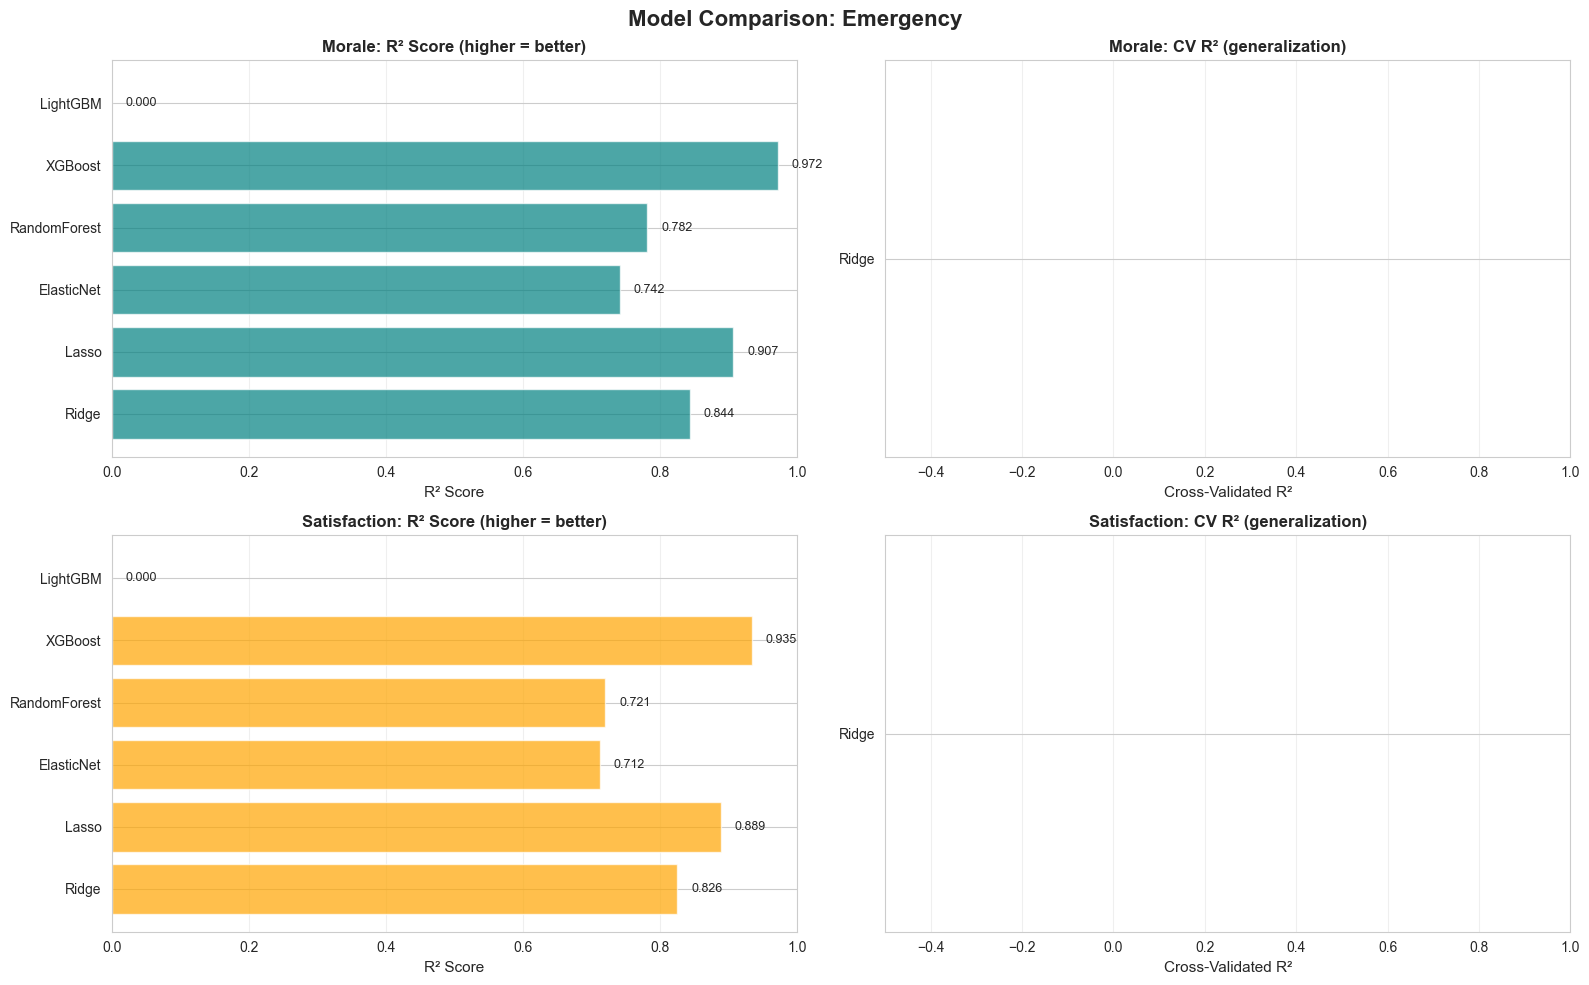

In [40]:
# Test for Emergency department
department = 'emergency'
X, y_morale, y_satisfaction, feature_names, n_staff = prepare_data_for_department(
    services_df, staff_schedule_df, department, week_range=(1, 52),
    include_interactions=False, log_transform=False
)

if X is not None:
    results_morale_emergency = compare_models(X, y_morale, f"{department} - Morale", n_staff=n_staff)
    results_satisfaction_emergency = compare_models(X, y_satisfaction, f"{department} - Satisfaction", n_staff=n_staff)
    
    plot_model_comparison(results_morale_emergency, results_satisfaction_emergency, department)


Department: SURGERY
Valid weeks: 35 (excluded 17 anomaly weeks)
Active staff: 25
Events: 4
Total features: 29
Samples: 35

Model Comparison: surgery - Morale
       Model       R²       MAE      RMSE  CV R² (LOO)   CV Std Non-zero feats Staff selected  CV R² (10-fold)
       Ridge 0.585147  9.650787 11.044167          NaN      NaN             29             25              NaN
       Lasso 0.673202  8.518430  9.802247          NaN      NaN             24             22              NaN
  ElasticNet 0.508819 10.644685 12.017285          NaN      NaN             27             23              NaN
RandomForest 0.582510 10.007264 11.079211          NaN 4.728232              -              -        -3.914352
     XGBoost 0.858108  4.999149  6.458981          NaN 5.493384              -              -        -5.353193
    LightGBM 0.000000 15.322449 17.146904          NaN 4.745442              -              -        -2.769703


Model Comparison: surgery - Satisfaction
       Model       R²

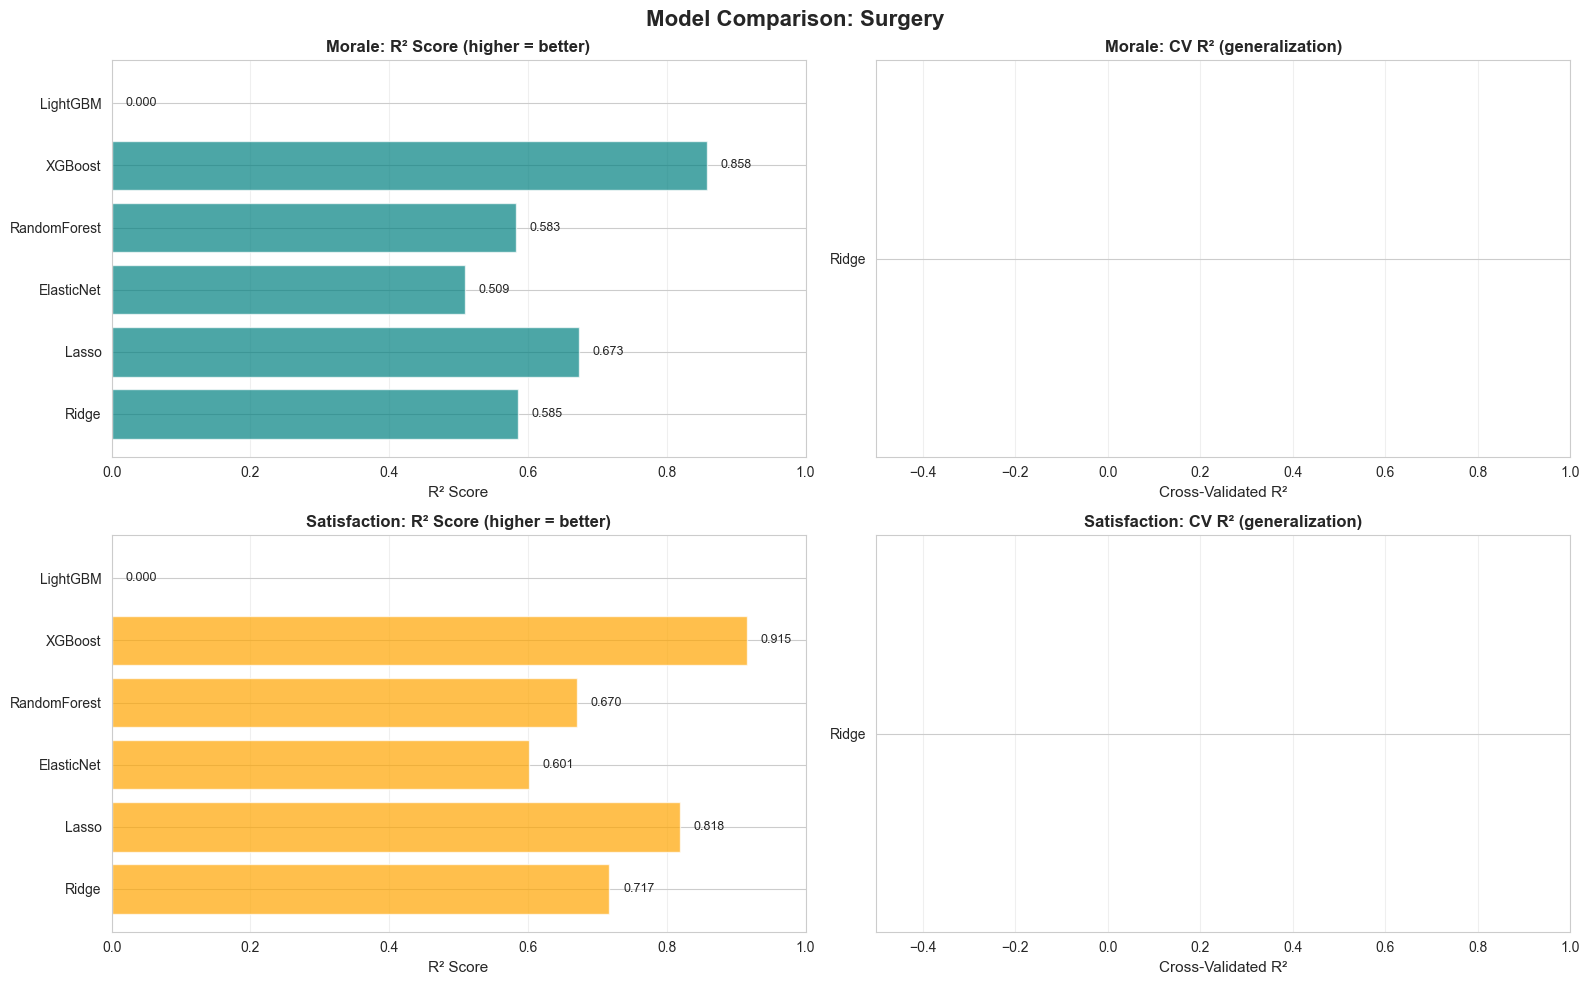

In [41]:
# Test for Surgery department
department = 'surgery'
X, y_morale, y_satisfaction, feature_names, n_staff = prepare_data_for_department(
    services_df, staff_schedule_df, department, week_range=(1, 52),
    include_interactions=False, log_transform=False
)

if X is not None:
    results_morale_surgery = compare_models(X, y_morale, f"{department} - Morale", n_staff=n_staff)
    results_satisfaction_surgery = compare_models(X, y_satisfaction, f"{department} - Satisfaction", n_staff=n_staff)
    
    plot_model_comparison(results_morale_surgery, results_satisfaction_surgery, department)


Department: GENERAL_MEDICINE
Valid weeks: 35 (excluded 17 anomaly weeks)
Active staff: 28
Events: 4
Total features: 32
Samples: 35

Model Comparison: general_medicine - Morale
       Model       R²       MAE      RMSE  CV R² (LOO)   CV Std Non-zero feats Staff selected  CV R² (10-fold)
       Ridge 0.672137  6.089757  7.994639          NaN      NaN             32             28              NaN
       Lasso 0.785698  4.891767  6.463478          NaN      NaN             25             23              NaN
  ElasticNet 0.564106  7.182110  9.218138          NaN      NaN             29             25              NaN
RandomForest 0.687779  6.594348  7.801597          NaN 0.732266              -              -        -1.224249
     XGBoost 0.904841  3.127363  4.307029          NaN 1.964253              -              -        -2.153627
    LightGBM 0.000000 11.288163 13.962165          NaN 1.275220              -              -        -0.981137


Model Comparison: general_medicine - Satisfa

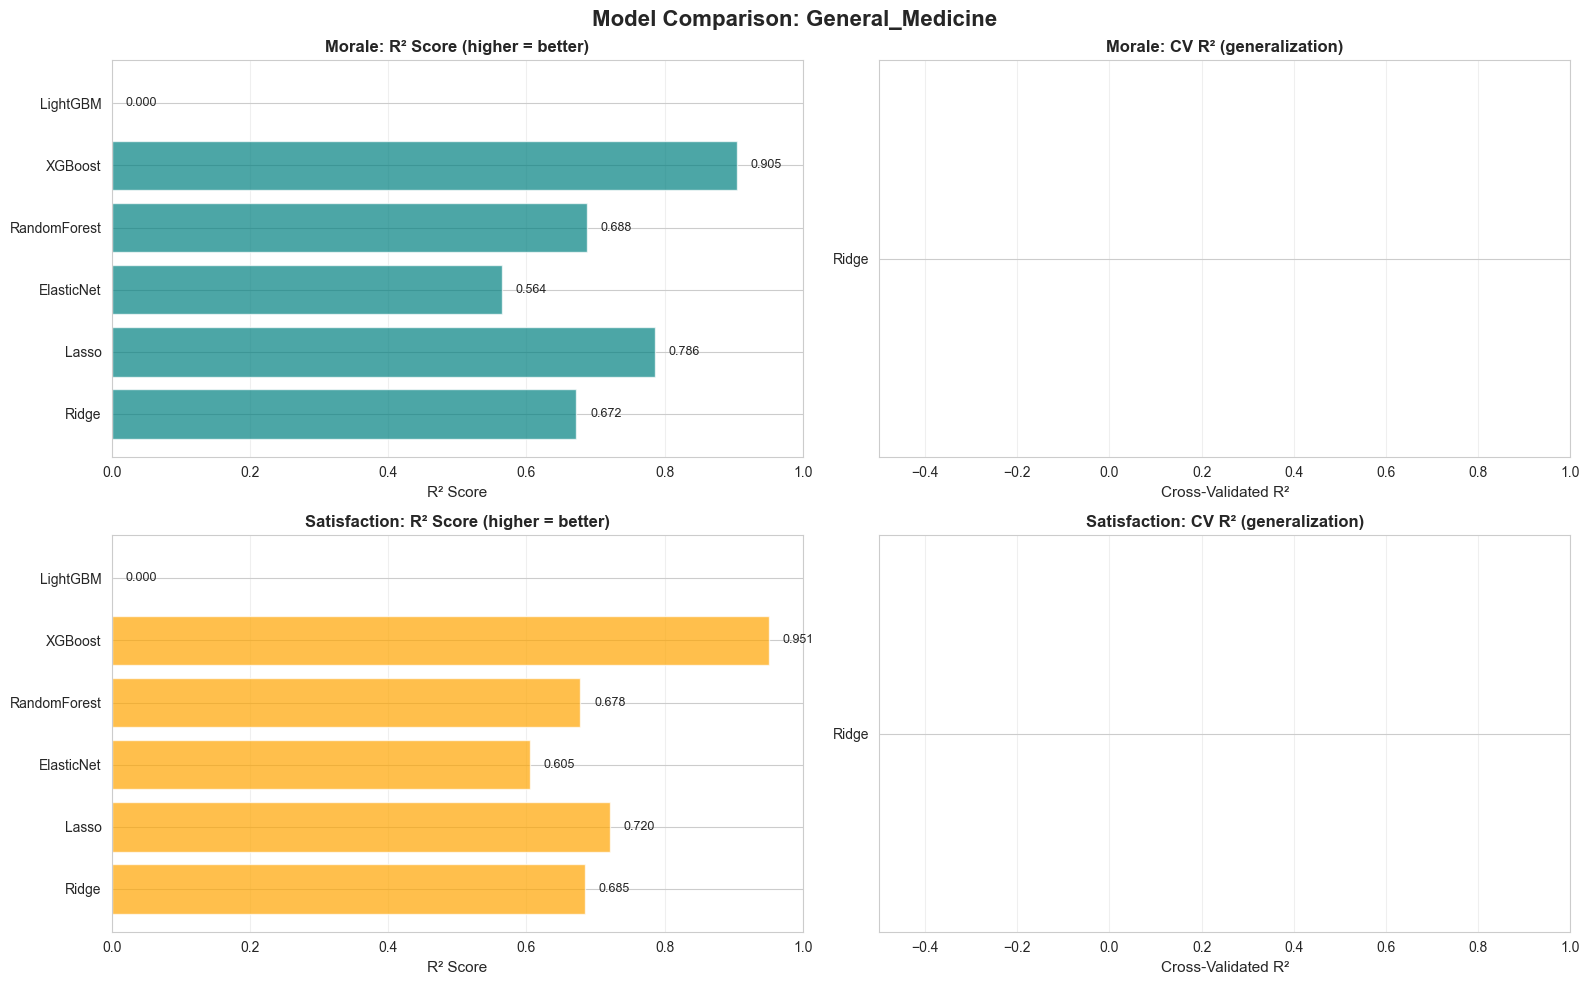

In [42]:
# Test for General Medicine department
department = 'general_medicine'
X, y_morale, y_satisfaction, feature_names, n_staff = prepare_data_for_department(
    services_df, staff_schedule_df, department, week_range=(1, 52),
    include_interactions=False, log_transform=False
)

if X is not None:
    results_morale_genmed = compare_models(X, y_morale, f"{department} - Morale", n_staff=n_staff)
    results_satisfaction_genmed = compare_models(X, y_satisfaction, f"{department} - Satisfaction", n_staff=n_staff)
    
    plot_model_comparison(results_morale_genmed, results_satisfaction_genmed, department)


Department: ICU
Valid weeks: 35 (excluded 17 anomaly weeks)
Active staff: 34
Events: 3
Total features: 37
Samples: 35

Model Comparison: ICU - Morale
       Model       R²       MAE      RMSE  CV R² (LOO)   CV Std Non-zero feats Staff selected  CV R² (10-fold)
       Ridge 0.749062  6.185197  7.328357          NaN      NaN             37             34              NaN
       Lasso 0.813650  5.320205  6.315209          NaN      NaN             23             22              NaN
  ElasticNet 0.659668  7.170593  8.534432          NaN      NaN             35             32              NaN
RandomForest 0.688751  7.196186  8.161643          NaN 3.224749              -              -        -1.895786
     XGBoost 0.920110  2.802440  4.134944          NaN 3.148483              -              -        -2.190067
    LightGBM 0.000000 13.281633 14.629297          NaN 2.123818              -              -        -1.312620


Model Comparison: ICU - Satisfaction
       Model       R²      MAE   

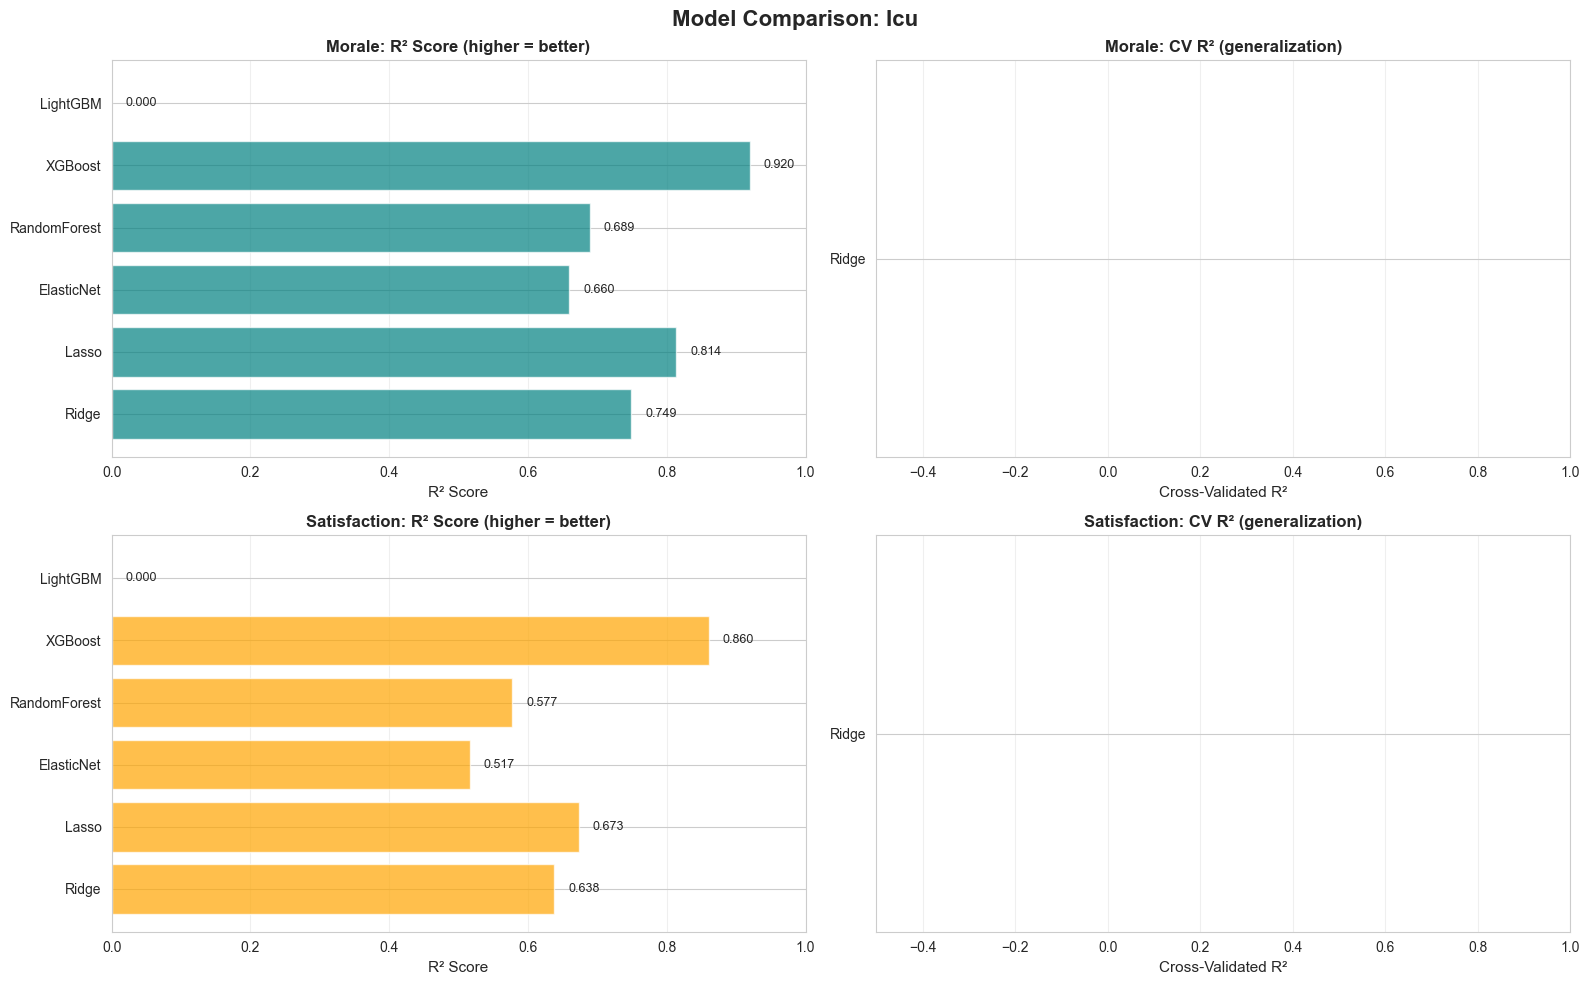

In [43]:
# Test for ICU department
department = 'ICU'
X, y_morale, y_satisfaction, feature_names, n_staff = prepare_data_for_department(
    services_df, staff_schedule_df, department, week_range=(1, 52),
    include_interactions=False, log_transform=False
)

if X is not None:
    results_morale_icu = compare_models(X, y_morale, f"{department} - Morale", n_staff=n_staff)
    results_satisfaction_icu = compare_models(X, y_satisfaction, f"{department} - Satisfaction", n_staff=n_staff)
    
    plot_model_comparison(results_morale_icu, results_satisfaction_icu, department)

## Overall Summary

Compare average performance across all departments.

In [44]:
# Aggregate results (handle None cases)
all_morale_results_list = []
all_satisfaction_results_list = []

for dept_name, morale_res, sat_res in [
    ('emergency', results_morale_emergency, results_satisfaction_emergency),
    ('surgery', results_morale_surgery, results_satisfaction_surgery),
    ('general_medicine', results_morale_genmed, results_satisfaction_genmed),
    ('ICU', results_morale_icu, results_satisfaction_icu)
]:
    if morale_res is not None:
        all_morale_results_list.append(morale_res.assign(Department=dept_name))
    if sat_res is not None:
        all_satisfaction_results_list.append(sat_res.assign(Department=dept_name))

all_morale_results = pd.concat(all_morale_results_list, ignore_index=True)
all_satisfaction_results = pd.concat(all_satisfaction_results_list, ignore_index=True)

# Find CV column name
cv_col = [c for c in all_morale_results.columns if 'CV R²' in c][0]

# Average by model
avg_morale = all_morale_results.groupby('Model')[['R²', 'MAE', 'RMSE', cv_col]].mean()
avg_satisfaction = all_satisfaction_results.groupby('Model')[['R²', 'MAE', 'RMSE', cv_col]].mean()

print("\n" + "="*80)
print("AVERAGE PERFORMANCE ACROSS ALL DEPARTMENTS")
print("="*80)
print("\nMORALE:")
print(avg_morale.to_string())
print("\nSATISFACTION:")
print(avg_satisfaction.to_string())
print("="*80)


AVERAGE PERFORMANCE ACROSS ALL DEPARTMENTS

MORALE:
                    R²        MAE       RMSE  CV R² (LOO)
Model                                                    
ElasticNet    0.618715   7.652762   9.193592          NaN
Lasso         0.794997   5.549907   6.694658          NaN
LightGBM      0.000000  12.782041  14.883904          NaN
RandomForest  0.685241   7.296399   8.371395          NaN
Ridge         0.712523   6.574564   7.955261          NaN
XGBoost       0.913846   3.201250   4.299067          NaN

SATISFACTION:
                    R²       MAE       RMSE  CV R² (LOO)
Model                                                   
ElasticNet    0.608852  5.467277   6.545677          NaN
Lasso         0.775209  3.910232   4.847428          NaN
LightGBM      0.000000  8.784898  10.560591          NaN
RandomForest  0.661648  5.280030   6.100365          NaN
Ridge         0.716405  4.521098   5.535979          NaN
XGBoost       0.915367  2.196541   2.996781          NaN


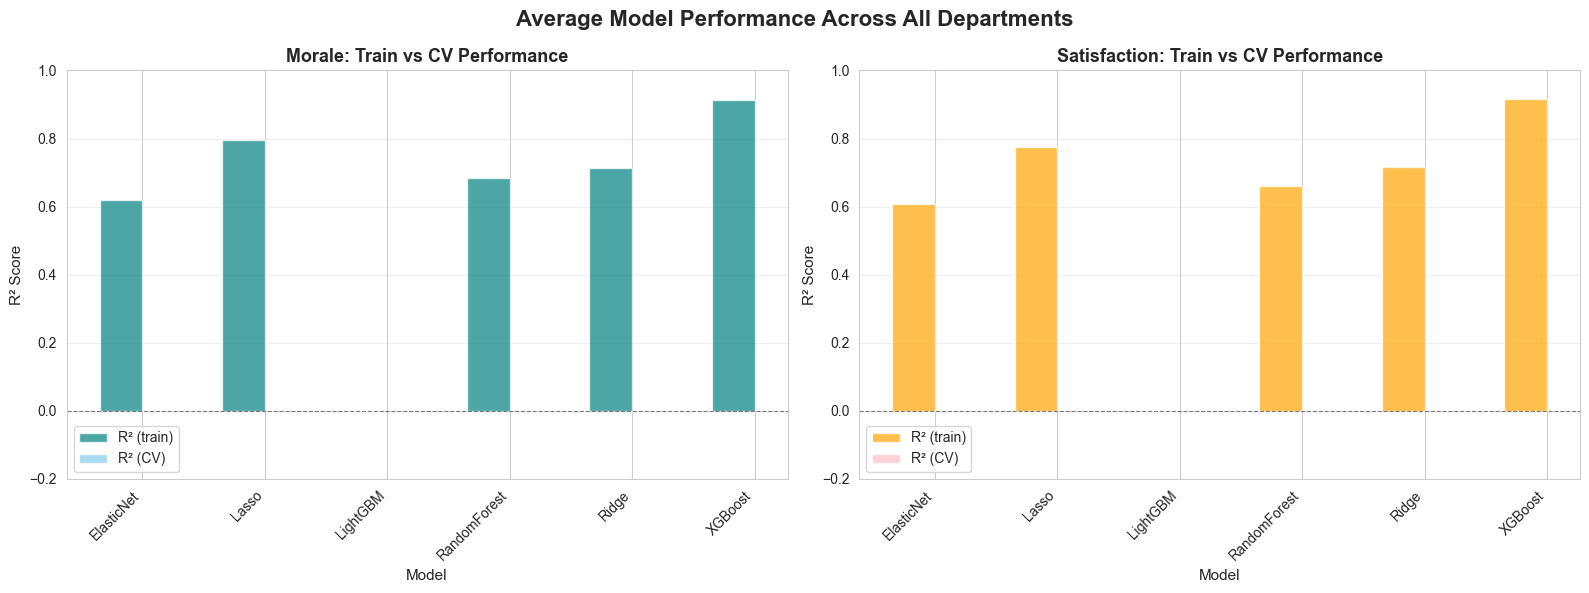

In [45]:
# Visualize average performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Average Model Performance Across All Departments', fontsize=16, fontweight='bold')

# Morale
ax1 = axes[0]
models = avg_morale.index
x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, avg_morale['R²'], width, label='R² (train)', color='teal', alpha=0.7)
ax1.bar(x + width/2, avg_morale[cv_col], width, label='R² (CV)', color='skyblue', alpha=0.7)
ax1.set_title('Morale: Train vs CV Performance', fontsize=13, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=11)
ax1.set_xlabel('Model', fontsize=11)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_ylim(-0.2, 1)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Satisfaction
ax2 = axes[1]
ax2.bar(x - width/2, avg_satisfaction['R²'], width, label='R² (train)', color='orange', alpha=0.7)
ax2.bar(x + width/2, avg_satisfaction[cv_col], width, label='R² (CV)', color='pink', alpha=0.7)
ax2.set_title('Satisfaction: Train vs CV Performance', fontsize=13, fontweight='bold')
ax2.set_ylabel('R² Score', fontsize=11)
ax2.set_xlabel('Model', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.set_ylim(-0.2, 1)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

**Key findings:**
1. **R² (train)**: Variance explained on training data - higher is better
2. **CV R²**: Cross-validated performance - measures generalization
   - LOO (Leave-One-Out) for linear models: most rigorous for small n
   - 10-fold for tree models: balances accuracy and speed
3. **Gap between R² and CV R²**: Large gap = overfitting
4. **Non-zero features**: Lasso/ElasticNet automatically select relevant staff
5. **Staff selected**: How many staff have non-zero impact

**Model characteristics:**
- **Ridge**: Keeps all features, shrinks coefficients, interpretable
- **Lasso**: Automatic feature selection, sparse solutions, interpretable
- **ElasticNet**: Balance of Ridge + Lasso, handles correlated features
- **RandomForest**: Non-linear, captures interactions, may overfit
- **XGBoost**: Powerful tree ensemble, handles interactions well
- **LightGBM**: Fast gradient boosting, good for small data

**Interaction terms:**
- Staff×Staff interactions capture teamwork effects
- Lasso/ElasticNet automatically zero out irrelevant pairs
- High-dimensional but regularization handles it

**Events:**
- Equipment failures, staff training affect outcomes independently
- Including them prevents misattributing event effects to staff

**Recommendation**: Choose model with:
- ✅ Highest CV R² (best generalization)
- ✅ Small gap between R² and CV R² (not overfitting)
- ✅ Stable performance across departments
- ✅ Interpretable coefficients (for visualization)

**For visualization**: Lasso or ElasticNet recommended because:
- Feature selection identifies truly important staff
- Interpretable coefficients for scatter plot
- Handles high-dimensional interaction terms
- Robust with small sample sizes

In [49]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score, LeaveOneOut
import warnings
warnings.filterwarnings('ignore')

# Load data
services_df = pd.read_csv('./data/services_weekly.csv')
staff_schedule_df = pd.read_csv('./data/staff_schedule.csv')

ANOMALY_WEEKS = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]

# Test Emergency department
department = 'emergency'
valid_weeks = [w for w in range(1, 53) if w not in ANOMALY_WEEKS]

dept_services = services_df[
    services_df['week'].isin(valid_weeks) & 
    (services_df['service'] == department)
].copy().sort_values('week').set_index('week')

dept_staff = staff_schedule_df[
    staff_schedule_df['week'].isin(valid_weeks) &
    (staff_schedule_df['service'] == department)
].copy()

# Create staff presence matrix
staff_presence = dept_staff.pivot_table(
    index='week',
    columns='staff_id',
    values='present',
    aggfunc='max',
    fill_value=0
)

staff_presence = staff_presence.reindex(dept_services.index, fill_value=0)

# Remove zero variance staff
staff_variance = staff_presence.var()
active_staff = staff_variance[staff_variance > 0].index
staff_presence = staff_presence[active_staff]

print(f"Department: {department}")
print(f"Samples: {len(staff_presence)}")
print(f"Features: {len(staff_presence.columns)}")
print(f"Staff presence dtype: {staff_presence.values.dtype}")
print(f"Any NaN in X: {pd.isna(staff_presence.values).any()}")
print(f"Any inf in X: {np.isinf(staff_presence.values).any()}")

X = staff_presence.values
y_morale = dept_services['staff_morale'].values

print(f"\nX shape: {X.shape}")
print(f"X dtype: {X.dtype}")
print(f"y shape: {y_morale.shape}")
print(f"y dtype: {y_morale.dtype}")
print(f"Any NaN in y: {pd.isna(y_morale).any()}")
print(f"y range: [{y_morale.min()}, {y_morale.max()}]")

# Test Ridge with LOO
print("\n" + "="*60)
print("Testing Ridge with LOO CV...")
print("="*60)

ridge = Ridge(alpha=1.0)
ridge.fit(X, y_morale)
print(f"Ridge fitted successfully")
print(f"Train R²: {ridge.score(X, y_morale):.4f}")

try:
    loo = LeaveOneOut()
    print(f"LOO splits: {loo.get_n_splits(X)}")
    
    # Manual CV to see what's happening
    scores = []
    for i, (train_idx, test_idx) in enumerate(loo.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_morale[train_idx], y_morale[test_idx]
        
        ridge_cv = Ridge(alpha=1.0)
        ridge_cv.fit(X_train, y_train)
        score = ridge_cv.score(X_test, y_test)
        scores.append(score)
        
        if i < 5:  # Print first 5
            print(f"  Fold {i}: train={len(train_idx)}, test={len(test_idx)}, R²={score:.4f}")
    
    scores = np.array(scores)
    print(f"\nManual LOO CV R²: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"Number of NaN scores: {np.isnan(scores).sum()}")
    print(f"Number of inf scores: {np.isinf(scores).sum()}")
    
    # Now test sklearn's cross_val_score
    print("\nTesting sklearn's cross_val_score...")
    cv_scores = cross_val_score(ridge, X, y_morale, cv=loo, scoring='r2')
    print(f"cross_val_score dtype: {cv_scores.dtype}")
    print(f"cross_val_score shape: {cv_scores.shape}")
    print(f"cross_val_score sample (first 5): {cv_scores[:5]}")
    print(f"cross_val_score mean: {cv_scores.mean()}")
    print(f"cross_val_score std: {cv_scores.std()}")
    print(f"Any NaN: {np.isnan(cv_scores).any()}")
    print(f"Any inf: {np.isinf(cv_scores).any()}")
    
except Exception as e:
    print(f"ERROR: {e}")
    import traceback
    traceback.print_exc()

Department: emergency
Samples: 35
Features: 39
Staff presence dtype: int64
Any NaN in X: False
Any inf in X: False

X shape: (35, 39)
X dtype: int64
y shape: (35,)
y dtype: int64
Any NaN in y: False
y range: [43, 99]

Testing Ridge with LOO CV...
Ridge fitted successfully
Train R²: 0.7484
LOO splits: 35
  Fold 0: train=34, test=1, R²=nan
  Fold 1: train=34, test=1, R²=nan
  Fold 2: train=34, test=1, R²=nan
  Fold 3: train=34, test=1, R²=nan
  Fold 4: train=34, test=1, R²=nan

Manual LOO CV R²: nan ± nan
Number of NaN scores: 35
Number of inf scores: 0

Testing sklearn's cross_val_score...
cross_val_score dtype: float64
cross_val_score shape: (35,)
cross_val_score sample (first 5): [nan nan nan nan nan]
cross_val_score mean: nan
cross_val_score std: nan
Any NaN: True
Any inf: False
